研究如何根据数据和相关知识高效、准确地建立贝叶斯网络，一直是近十年来的热点与难点。
目前对于这一类学习问题，主要有基于打分-搜索的学习方法和基于依赖分析的学习方法，但前者存在搜索空间巨大，可能收敛于局部最优解等问题；后者则存在结点之间的独立性或条件独立性的判断困难以及高阶条件独立性检验结果不够可靠等问题。

In [2]:
# 创建贝叶斯网
# 在 pgmpy 中, 定义一个贝叶斯网的流程一般是先建立网络结构, 然后填入相关参数.
from pgmpy.models import BayesianNetwork

cancer_model = BayesianNetwork([('Pollution', 'Cancer'),
                              ('Smoker', 'Cancer'),
                              ('Cancer', 'Xray'),
                              ('Cancer', 'Dyspnoea')])
# 这个网络中有五个节点: Pollution, Cancer, Smoker, Xray, Dyspnoea.
# ('Pollution', 'Cancer'): 一条有向边, 从 Pollution 指向 Cancer, 表示环境污染有可能导致癌症.
# ('Smoker', 'Cancer'): 吸烟有可能导致癌症.
# ('Cancer', 'Xray'): 得癌症的人可能会去照X射线.
# ('Cancer', 'Dyspnoea'): 得癌症的人可能会呼吸困难.

In [2]:
# 构建模型参数
from pgmpy.factors.discrete import TabularCPD

'''
CPD（condition probability distribution）表格
variable：变量名
variable_card：基数（可影响的变量数）,如I有两个可能：True/false，就是2
values：变量值的可能概率取值
evidence：指向该变量（会导致该事件的事件）即父亲节点都有哪些。
evidence_card：每个evidence事件对应的可能数，如N的L有True和False，则为2
'''
cpd_poll = TabularCPD(variable='Pollution', variable_card=2, values=[[0.9], [0.1]])
cpd_smoke = TabularCPD(variable='Smoker', variable_card=2, values=[[0.3], [0.7]])
cpd_cancer = TabularCPD(variable='Cancer', variable_card=2,
                        values=[[0.03, 0.05, 0.001, 0.02], [0.97, 0.95, 0.999, 0.98]],
                        evidence=['Smoker', 'Pollution'], evidence_card=[2, 2])
# 注意条件概率表的情况和对应概率大小
cpd_xray = TabularCPD(variable='Xray', variable_card=2,
                      values=[[0.9, 0.2], [0.1, 0.8]],
                      evidence=['Cancer'], evidence_card=[2])
cpd_dysp = TabularCPD(variable='Dyspnoea', variable_card=2,
                      values=[[0.65, 0.3], [0.35, 0.7]],
                      evidence=['Cancer'], evidence_card=[2])

In [3]:
# 将数据加入网络。将参数与模型结构相关联。
cancer_model.add_cpds(cpd_poll, cpd_smoke, cpd_cancer, cpd_xray, cpd_dysp)
# 检查cpds对于模型是否可用。验证模型数据的正确性(猜测是验证相关数据的和是否为1, 验证数据中是否有负数, 等等)可以看源码
cancer_model.check_model()

True

In [4]:
# 判断两个节点之间是否存在有效迹。
'''
is_dconnected(start, end, observed=None)
is_dconnected(start, end, observed=None)
输入参数：
start(int, str, any hashable python object): 有效迹起点
end(int,str, any hashable python object): 有效迹终点
observed(list): 已观测节点列表，会根据已观测节点计算有效迹
返回值：
(bool): 起点和终点间是否存在有效迹
'''
# 相关的检查,判断网络是否正确，判断模型两个节点是否可达,即有效迹
print(cancer_model.is_dconnected('Pollution', 'Smoker'))
print(cancer_model.is_dconnected('Pollution', 'Smoker', observed=['Cancer']))

False
True


In [5]:
# 局部马尔可夫性（局部独立性)
'''
给定某节点的父节点集，则该节点条件独立于它的所有非后代节点。
local_independencies(variables)
输入变量：variables(str or array like): 寻找局部独立的目标节点
返回值：(Independencies对象): 独立性断言
'''
# (Xray _|_ Dyspnoea, Smoker, Pollution | Cancer)
print(cancer_model.local_independencies('Xray'))
print(cancer_model.local_independencies('Dyspnoea'))
print(cancer_model.local_independencies('Pollution'))

(Xray ⟂ Dyspnoea, Pollution, Smoker | Cancer)
(Dyspnoea ⟂ Xray, Pollution, Smoker | Cancer)
(Pollution ⟂ Smoker)


In [6]:
# 最小d分隔节点集，即使得 start 和 end 独立（分开）的最少节点集合。
'''
minimal_dseparator(start, end)
输入变量：start(node): 第一个节点 end(node): 第二个节点
返回值：(list): 将第一个节点和第二个节点d分隔的最小节点集
'''
# 例如
from pgmpy.base import DAG

dag = DAG([('A', 'B'), ('B', 'C')])
print(dag.minimal_dseparator(start='A', end='C'))

{'B'}


## 绘制构建的网络结构

In [7]:
# 绘图, DAG.to_daft().render() 转换对象并展现
'''
pgmpy支持将DAG图导出为daft.PGM对象（https://docs.daft-pgm.org/en/latest/），
该对象可调用show()函数绘制出高质量的图形。
to_daft(node_pos=‘circular’, latex=True, pgm_params={}, edge_params={}, node_params={})
输入参数：node_pos(str or dict): 若是字符串，则只能是如下几种:
circular, kamada_kawai, planar, random, shell, sprint, spectral, spiral. 若为字典，则可枚举各节点的位置，格式为{node1:(x轴坐标, y轴坐标), …}

latex(bool): 是否使用latex渲染节点名
pgm_params(dict): 传递给daft.PGM对象初始化函数的参数，格式为{param_name: param_value, …}
edge_params(dict): 传递给daft.add_edge方法的参数，格式为{(u1,v1):{param_name: param_value, …}, …}
node_params(dict): 传递给daft.add_node方法的参数，格式为{node1:{param_name: param_value, …}, …}
返回值：一个可以通过调用 .render() 展现；表现;呈现  方法显示图片。
'''
import daft
import matplotlib.pyplot as plt

In [8]:
% matplotlib inline

<Axes:>

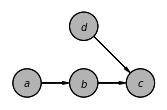

In [9]:
dag = DAG([('a', 'b'), ('b', 'c'), ('d', 'c')])
a = dag.to_daft(node_pos={'a': (0, 0), 'b': (1, 0), 'c': (2, 0), 'd': (1, 1)})
a.render()

<Axes:>

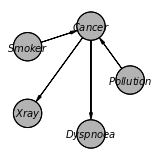

In [10]:
cancer_model_plot = cancer_model.to_daft()
cancer_model_plot.render()

In [11]:
# 使用网络进行推理。推理算法分精确推理和近似推理. 精确推理有变量消元法和团树传播法; 近似推理算法是基于随机抽样的算法.
# 变量消除法

In [12]:
'''
.bif扩展名也被选择来代表贝叶斯交换格式（BIF），该格式是在1996年左右提出的，作为描述贝叶斯或信念网络的标准方式。
后来，BIF被放弃，而采用了新的、基于XML的XMLBIF格式（.xmlbif）。

Asia 网络是早期贝叶斯网文献中给出的一个网络, 与肺结核, 肺癌, 支气管炎等有关, 和我们之前的那个网络很相似. 我们使用 Asia 网络来看一下如何进行推理.
'''
# 导入 Asia 网络
from pgmpy.readwrite import BIFReader

reader = BIFReader('asia.bif', n_jobs=2)
asia_model = reader.get_model()
# 输出节点信息
print(asia_model.nodes())

['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']


In [13]:
# 输出依赖关系
print(asia_model.edges())

[('asia', 'tub'), ('tub', 'either'), ('smoke', 'lung'), ('smoke', 'bronc'), ('lung', 'either'), ('bronc', 'dysp'), ('either', 'xray'), ('either', 'dysp')]


In [14]:
# 查看概率分布
print(asia_model.get_cpds())

[<TabularCPD representing P(asia:2) at 0x17ff0015430>, <TabularCPD representing P(bronc:2 | smoke:2) at 0x17ff00154c0>, <TabularCPD representing P(dysp:2 | bronc:2, either:2) at 0x17ff0015520>, <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x17ff00155e0>, <TabularCPD representing P(lung:2 | smoke:2) at 0x17ff00156d0>, <TabularCPD representing P(smoke:2) at 0x17ff0015730>, <TabularCPD representing P(tub:2 | asia:2) at 0x17ff00157c0>, <TabularCPD representing P(xray:2 | either:2) at 0x17ff0015850>]


In [15]:
# 直观显示某节点的概率分布
print(asia_model.get_cpds('xray'))

+-----------+-------------+------------+
| either    | either(yes) | either(no) |
+-----------+-------------+------------+
| xray(yes) | 0.98        | 0.05       |
+-----------+-------------+------------+
| xray(no)  | 0.02        | 0.95       |
+-----------+-------------+------------+


<Axes:>

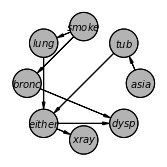

In [16]:
# 展示一下结构图
asia_model.to_daft().render()

## 根据已经构建的网络模型进行推断

In [21]:
# 变量消除法,变量消除法是精确推断的一种方法.
from pgmpy.inference import VariableElimination

asia_infer = VariableElimination(asia_model)  # 实例化推断
q = asia_infer.query(variables=['bronc'], evidence={'smoke': 0})  # query() 查询函数，给定条件进行推断
print(q)  # 意思是, 在不吸烟的情况下, 得支气管炎的概率是 0.4, 未得支气管炎的概率是 0.6.

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+--------------+
| bronc      |   phi(bronc) |
+============+==============+
| bronc(yes) |       0.6000 |
+------------+--------------+
| bronc(no)  |       0.4000 |
+------------+--------------+


In [22]:
q = asia_infer.query(variables=['bronc'], evidence={'smoke': 1})
print(q)  # 在在吸烟情况下, 得支气管炎的概率和未得支气管炎的概率可以这样查询

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+--------------+
| bronc      |   phi(bronc) |
+============+==============+
| bronc(yes) |       0.3000 |
+------------+--------------+
| bronc(no)  |       0.7000 |
+------------+--------------+


## 根据 已有结构 和 数据数据 进行参数学习

In [24]:
# 利用训练数据学习
'''
场景: 投硬币, 训练数据中, 有 30% 的正面朝上, 有 70% 的反面朝上. 我们使用极大似然估计和狄利克雷分布下贝叶斯参数先验估计硬币的条件概率分布
'''
# 生成数据
import numpy as np
import pandas as pd

raw_data = np.array([0] * 30 + [1] * 70)
data = pd.DataFrame(raw_data, columns=['coin'])
# 定义贝叶斯网
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

model = BayesianNetwork()
model.add_node('coin')
# 使用极大似然估计:
model.fit(data, estimator=MaximumLikelihoodEstimator)
print(model.get_cpds('coin'))

+---------+-----+
| coin(0) | 0.3 |
+---------+-----+
| coin(1) | 0.7 |
+---------+-----+


In [31]:
# 使用狄利克雷分布作为先验分布的贝叶斯推论
model.fit(data, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts={'coin': [[50], [50]]})
print(model.get_cpds('coin'))

+---------+-----+
| coin(0) | 0.4 |
+---------+-----+
| coin(1) | 0.6 |
+---------+-----+


In [39]:
'''
变量	            含义         取值
Difficulty      课程本身难度  0=easy, 1=difficult
Intelligence	学生聪明程度	0=stupid, 1=smart
Grade	        学生课程成绩	1=A, 2=B
SAT	            学生高考成绩	0=low, 1=high
Letter	        可否获得推荐信	0=未获得, 1=获得
'''
# 随机生成数据
raw_data_2 = np.random.randint(0, 2, size=(1000, 5))
data = pd.DataFrame(raw_data_2, columns=['D', 'I', 'G', 'L', 'S'])
# 形成贝叶斯网络
model = BayesianNetwork([('D', 'G'), ('I', 'G'), ('I', 'S'), ('G', 'L')])
model.fit(data, estimator=MaximumLikelihoodEstimator)
for i in model.get_cpds():
    print(i)

+------+-------+
| D(0) | 0.509 |
+------+-------+
| D(1) | 0.491 |
+------+-------+
+------+---------------------+-----+--------------------+
| D    | D(0)                | ... | D(1)               |
+------+---------------------+-----+--------------------+
| I    | I(0)                | ... | I(1)               |
+------+---------------------+-----+--------------------+
| G(0) | 0.5275590551181102  | ... | 0.5278969957081545 |
+------+---------------------+-----+--------------------+
| G(1) | 0.47244094488188976 | ... | 0.4721030042918455 |
+------+---------------------+-----+--------------------+
+------+-------+
| I(0) | 0.512 |
+------+-------+
| I(1) | 0.488 |
+------+-------+
+------+-------------+---------------------+
| I    | I(0)        | I(1)                |
+------+-------------+---------------------+
| S(0) | 0.505859375 | 0.5163934426229508  |
+------+-------------+---------------------+
| S(1) | 0.494140625 | 0.48360655737704916 |
+------+-------------+----------------

In [47]:

'''
参数学习
=================================================   需要了解各种参数的具体取值情况的含义  =========================================
问题一：pseudo_counts 是什么？
问题二：prior_type


BN网络模型学习的API接口： fit 基于给定的数据进行学习变量的 CPD
fit(data, estimator=None, state_names=[], complete_samples_only=True, n_jobs=- 1, **kwargs)
data：pandas DataFrame, 且列名和网络种的名字一致；数据缺失时，设置为 numpy 的 np.NaN ,pandas 会将其转为 float32 的数据类型。

estimator：Estimator class 默认为 极大似然估计。这个例子中 值为：BayesianEstimator 传递“prior_type”和“pseudo_counts”或“equivalent_sample_size”作为附加关键字参数

state_names： 字典形式，表明 变量可以采取的离散的变量集合， 如果未指定 数据集中观察到的值被视为唯一可能的状态。

complete_samples_only ：仅用完整的数据 (bool (default True)) 用于指定如何处理缺失值，如果为 True 那么包含 np.NaN 的数据行将被忽略掉。 如果为false 则无论是父级节点还是变量自身，都使用 np.NaN

n_jobs ：(int (default: -1)) 用于估计的线程/进程数。它仅提高了大型网络（>100个节点）的速度。对于较小的网络，可能会降低性能。
'''
pseudo_counts = {'D': [[300], [700]], 'I': [[500], [500]], 'G': [[800, 100, 100, 200], [200,  900, 900, 800]], 'L': [[500, 500], [500, 500]], 'S': [[400, 300], [600, 700]]}
model.fit(data, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=pseudo_counts)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of D:
+------+--------+
| D(0) | 0.4045 |
+------+--------+
| D(1) | 0.5955 |
+------+--------+
CPD of G:
+------+--------------------+-----+--------------------+
| D    | D(0)               | ... | D(1)               |
+------+--------------------+-----+--------------------+
| I    | I(0)               | ... | I(1)               |
+------+--------------------+-----+--------------------+
| G(0) | 0.74481658692185   | ... | 0.2619626926196269 |
+------+--------------------+-----+--------------------+
| G(1) | 0.2551834130781499 | ... | 0.7380373073803731 |
+------+--------------------+-----+--------------------+
CPD of I:
+------+-------+
| I(0) | 0.506 |
+------+-------+
| I(1) | 0.494 |
+------+-------+
CPD of S:
+------+---------------------+--------------------+
| I    | I(0)                | I(1)               |
+------+---------------------+--------------------+
| S(0) | 0.43584656084656087 | 0.3709677419354839 |
+------+---------------------+--------------------+
| S(1) | 0.5

In [50]:
# 概率图模型(Probabilistic Graphical Models)